<a href="https://colab.research.google.com/github/ManelSoengas/NLP_Curs/blob/main/Utilitzant_Tranformers_Construint_Tokenizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Construint un tokenitzador, bloc a bloc**

---

Recordem que la tokenització consta de diversos passos:

1. **Normalització** (qualsevol neteja del text que es consideri necessària, com eliminar espais o accents, normalització Unicode, etc.)
1. **Pre-tokenització** (dividir l'entrada en paraules)
Execució de l'entrada a través del model (utilitzant les paraules pre-tokenitzades per produir una seqüència de fitxes)
1. **Postprocessament** (afegir les fitxes especials del tokenitzador, generant la màscara d'atenció i els identificadors de tipus de testimoni)

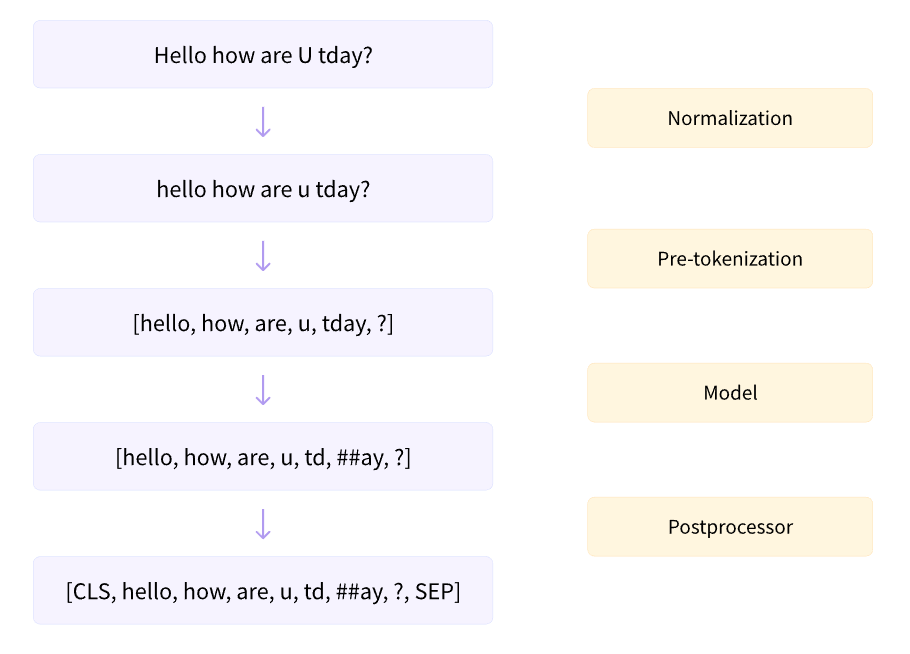

# **Adquisició d'un corpus**

---
Per entrenar el nou tokenizer, utilitzarem un petit corpus de text (així que els exemples funcionin ràpidament), aquesta vegada utilitzarem el conjunt de dades WikiText-2:


In [ ]:
!pip install datasets

from datasets import load_dataset

dataset = load_dataset("wikitext", name="wikitext-2-raw-v1", split="train")


def get_training_corpus():
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]

# **Construir un tokenitzador de WordPiece des de zero**

---

1. **Tokenizer**:

Crear un nou objecte "tokenitzador" (Tokenizer).

Aquest objecte serveix per dividir el text en unitats (tokens) que després un model d'IA pot processar.

1. **models.WordPiece(...)**:

Indicar que el mètode de tokenització serà WordPiece.

WordPiece és un algorisme molt conegut (utilitzat per models com BERT), que trenca paraules en subparts si no estan al vocabulari.
(Ex: "increïble" → "in", "cre", "ïble" si no coneix tota la paraula.)

1. **unk_token="[UNK]"**:

[UNK] és el símbol per als tokens desconeguts.

Si troba una paraula que no pot tokenitzar (per exemple, una paraula molt rara o inventada), la substituirà pel token [UNK].

In [ ]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))

El primer pas de la tokenització és la normalització, així que comencem per això. Com que BERT és molt utilitzat, hi ha un BertNormalizer amb les opcions clàssiques que podem establir per a BERT: minúscules i strip_accents, que s'explicaran per si mateixes; clean_text per eliminar tots els caràcters de control i substituir els espais que es repeteixen per un de sol; i handle_chinese_chars, que col·loca espais al voltant dels caràcters xinesos. Per replicar el tokenitzador bert-base-uncased, només podem configurar aquest normalitzador:

In [ ]:
tokenizer.normalizer = normalizers.BertNormalizer(lowercase=True)

Configurant a mà

In [ ]:
tokenizer.normalizer = normalizers.Sequence(
    [normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()]
)

In [ ]:
print(tokenizer.normalizer.normalize_str("Héllò hôw are ü?"))

El següent és el pas previ a la tokenització. De nou, hi ha un BertPreTokenizer preconstruït que podem utilitzar:

In [ ]:
tokenizer.pre_tokenizer = pre_tokenizers.BertPreTokenizer()
tokenizer.pre_tokenizer.pre_tokenize_str("Let's test my pre-tokenizer.")

El següent pas del pipeline de tokenització és executar les entrades a través del model. Ja hem especificat el nostre model a la inicialització, però encara hem d'entrenar-lo, cosa que requerirà un WordPieceTrainer. El més important a recordar quan s'instancia un entrenador a Tokenizers és que cal passar-li totes les fitxes especials que voleu utilitzar; en cas contrari, no les afegirà al vocabulari, ja que no es troben al corpus d'entrenament:

In [ ]:
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.WordPieceTrainer(vocab_size=25000, special_tokens=special_tokens)

Per entrenar el model utilitzant l'iterador que hem definit anteriorment, només hem d'executar aquesta ordre:

In [ ]:
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

In [ ]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

La codificació obtinguda és una codificació, que conté totes les sortides necessàries del tokenizer en els seus diferents atributs: ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask i overflowing.

L'últim pas del pipeline de tokenització és el postprocessament. Hem d'afegir el testimoni [CLS] al principi i el testimoni [SEP] al final (o després de cada frase, si tenim un parell d'oracions). Utilitzarem un TemplateProcessor per a això, però primer hem de conèixer els ID de les fitxes [CLS] i [SEP] del vocabulari.

1. **tokenizer.token_to_id("[CLS]")**:
demana l'ID numèric (l'identificador) associat al token especial [CLS].

1. **tokenizer.token_to_id("[SEP]")**:
el mateix però pel token [SEP].

1. **print(cls_token_id, sep_token_id)**:
imprimeix aquests dos IDs per veure quins números tenen assignats.

1. **[CLS] (Classify) i [SEP] (Separator)** són tokens especials molt utilitzats:

  * [CLS]: es posa al principi del text perquè el model el pugui usar per classificacions.

  * [SEP]: es posa entre frases o al final per separar textos.

In [ ]:
cls_token_id = tokenizer.token_to_id("[CLS]")
sep_token_id = tokenizer.token_to_id("[SEP]")
print(cls_token_id, sep_token_id)

In [ ]:
tokenizer.post_processor = processors.TemplateProcessing(
    single=f"[CLS]:0 $A:0 [SEP]:0",
    pair=f"[CLS]:0 $A:0 [SEP]:0 $B:1 [SEP]:1",
    special_tokens=[("[CLS]", cls_token_id), ("[SEP]", sep_token_id)],
)

Configurant el post-processador del tokenitzador.

* processors.TemplateProcessing(...) permet afegir automàticament aquests tokens
 especials a les seqüències tokenitzades, seguint un patró que tu especifiques.

In [ ]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

In [ ]:
encoding = tokenizer.encode("Let's test this tokenizer...", "on a pair of sentences.")
print(encoding.tokens)
print(encoding.type_ids)

Una vegada acabat de construir aquest tokenitzador des de zero; l'últim pas és incloure un descodificador:

In [ ]:
tokenizer.decoder = decoders.WordPiece(prefix="##")

In [ ]:
tokenizer.decode(encoding.ids)

# **Emmagatzenar i carregar el tokenizer creat**

---



In [ ]:
tokenizer.save("/content/tokenizer.json")

In [ ]:
new_tokenizer = Tokenizer.from_file("/content/tokenizer.json")

Per utilitzar aquest tokenizer a 🤗 Transformers, l'hem d'embolicar en un PreTrainedTokenizerFast. Podem utilitzar la classe genèrica o, si el nostre tokenizer correspon a un model existent, utilitzar aquesta classe (aquí, BertTokenizerFast). Si apliqueu aquesta lliçó per crear un tokenitzador nou, haureu d'utilitzar la primera opció.

Per embolicar el tokenizer en un PreTrainedTokenizerFast, podem passar el tokenizer que hem creat com a tokenizer_object o bé passar el fitxer tokenizer que hem desat com a tokenizer_file. El més important a recordar és que hem d'establir manualment tots els fitxes especials, ja que aquesta classe no pot inferir de l'objecte del tokenizer quin testimoni és el testimoni de màscara, el testimoni [CLS], etc.:

```
from transformers import PreTrainedTokenizerFast

# Carregar el tokenizer a partir del fitxer JSON
tokenizer = PreTrainedTokenizerFast(tokenizer_file="ruta/al/teu_tokenizer.json")

```


```
from transformers import PreTrainedTokenizerFast

wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    # tokenizer_file="tokenizer.json", # You can load from the tokenizer file, alternatively
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)
```




# **Construir un tokenitzador BPE des de zero**

---
Creem ara un tokenitzador GPT-2. Igual que amb el tokenizer BERT, comencem inicialitzant un Tokenizer amb un model BPE:


In [9]:
from tokenizers import Tokenizer, models, pre_tokenizers, trainers


tokenizer = Tokenizer(models.BPE())

També com per a BERT, podríem inicialitzar aquest model amb un vocabulari si en tinguéssim un (en aquest cas caldria passar el vocabulari i fusionar), però com que entrenarem des de zero, no cal que ho fem. Tampoc cal que especifiquem un unk_token perquè GPT-2 utilitza BPE a nivell de bytes, que no ho requereix.

GPT-2 no utilitza un normalitzador, així que ens saltem aquest pas i anem directament a la pre-tokenització:

In [10]:
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)

In [ ]:
[('Let', (0, 3)), ("'s", (3, 5)), ('Ġtest', (5, 10)), ('Ġpre', (10, 14)), ('-', (14, 15)),
 ('tokenization', (15, 27)), ('!', (27, 28))]

In [13]:
def get_training_corpus():
    return [
        "Això és un exemple de text.",
        "Estem entrenant un tokenizer amb BPE.",
        "La intel·ligència artificial és una eina potent.",
        "Les dades són importants per a l’aprenentatge automàtic.",
        "OpenAI ha desenvolupat aquest sistema.",
    ]


El següent és el model, que necessita formació. Per a GPT-2, l'únic testimoni especial és el testimoni de final de text:

In [14]:
trainer = trainers.BpeTrainer(vocab_size=25000, special_tokens=["<|endoftext|>"])
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

Fem una ullada a la tokenització d'un text de mostra:

In [ ]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

Apliquem el postprocessament a nivell de bytes per al tokenitzador GPT-2 de la següent manera:

In [17]:
from tokenizers import processors

tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)

L'opció trim_offsets = False indica al postprocessador que hem de deixar els desplaçaments de fitxes que comencen per 'Ġ' tal com estan: d'aquesta manera l'inici dels desplaçaments apuntarà a l'espai abans de la paraula, no al primer caràcter de la paraula (ja que tècnicament l'espai forma part de la fitxa). Fem una ullada al resultat amb el text que acabem de codificar, on 'Ġtest' és el testimoni de l'índex 4:

In [ ]:
sentence = "Let's test this tokenizer."
encoding = tokenizer.encode(sentence)
start, end = encoding.offsets[4]
sentence[start:end]

In [20]:

from tokenizers import decoders
tokenizer.decoder = decoders.ByteLevel()

In [ ]:
tokenizer.decode(encoding.ids)

Genial! Ara que hem acabat, podem desar el tokenizer com abans i embolicar-lo en un PreTrainedTokenizerFast o GPT2TokenizerFast si el volem utilitzar a Transformers:

# **Construir un tokenizer Unigram des de zero**

---



In [22]:
tokenizer = Tokenizer(models.Unigram())

De nou, podríem inicialitzar aquest model amb un vocabulari si en tinguéssim un.

Per a la normalització, XLNet utilitza alguns substituts (que provenen de SentencePiece):

In [24]:
from tokenizers import Regex, normalizers

tokenizer.normalizer = normalizers.Sequence(
    [
        normalizers.Replace("``", '"'),
        normalizers.Replace("''", '"'),
        normalizers.NFKD(),
        normalizers.StripAccents(),
        normalizers.Replace(Regex(" {2,}"), " "),
    ]
)

Això substitueix " and " with " i qualsevol seqüència de dos o més espais amb un únic espai, a més d'eliminar els accents dels textos per simbolitzar.

El pre-tokenitzador que cal utilitzar per a qualsevol tokenitzador SentencePiece és Metaspace:

In [25]:
tokenizer.pre_tokenizer = pre_tokenizers.Metaspace()

Podem fer una ullada a la pre-tokenització d'un text d'exemple com abans:

In [ ]:
tokenizer.pre_tokenizer.pre_tokenize_str("Let's test the pre-tokenizer!")

El següent és el model, que necessita formació. XLNet té força fitxes especials:

In [27]:
special_tokens = ["<cls>", "<sep>", "<unk>", "<pad>", "<mask>", "<s>", "</s>"]
trainer = trainers.UnigramTrainer(
    vocab_size=25000, special_tokens=special_tokens, unk_token="<unk>"
)
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

Un argument molt important a no oblidar per a UnigramTrainer és el unk_token. També podem transmetre altres arguments específics de l'algoritme Unigram, com ara el factor de reducció per a cada pas on eliminem fitxes (per defecte a 0,75) o el max_piece_length per especificar la longitud màxima d'un testimoni donat (per defecte a 16).

Aquest tokenitzador també es pot entrenar en fitxers de text:

In [ ]:
tokenizer.model = models.Unigram()
tokenizer.train(["wikitext-2.txt"], trainer=trainer)

In [ ]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

In [ ]:
cls_token_id = tokenizer.token_to_id("<cls>")
sep_token_id = tokenizer.token_to_id("<sep>")
print(cls_token_id, sep_token_id)

In [ ]:
tokenizer.post_processor = processors.TemplateProcessing(
    single="$A:0 <sep>:0 <cls>:2",
    pair="$A:0 <sep>:0 $B:1 <sep>:1 <cls>:2",
    special_tokens=[("<sep>", sep_token_id), ("<cls>", cls_token_id)],
)

In [ ]:
encoding = tokenizer.encode("Let's test this tokenizer...", "on a pair of sentences!")
print(encoding.tokens)
print(encoding.type_ids)

In [ ]:
tokenizer.decoder = decoders.Metaspace()

In [ ]:
from transformers import PreTrainedTokenizerFast

wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    bos_token="<s>",
    eos_token="</s>",
    unk_token="<unk>",
    pad_token="<pad>",
    cls_token="<cls>",
    sep_token="<sep>",
    mask_token="<mask>",
    padding_side="left",
)